<>:170: SyntaxWarning: invalid escape sequence '\s'
<>:180: SyntaxWarning: invalid escape sequence '\s'
<>:170: SyntaxWarning: invalid escape sequence '\s'
<>:180: SyntaxWarning: invalid escape sequence '\s'
C:\Users\soura\AppData\Local\Temp\ipykernel_23832\679722223.py:170: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')
C:\Users\soura\AppData\Local\Temp\ipykernel_23832\679722223.py:180: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')
C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\soura\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory l

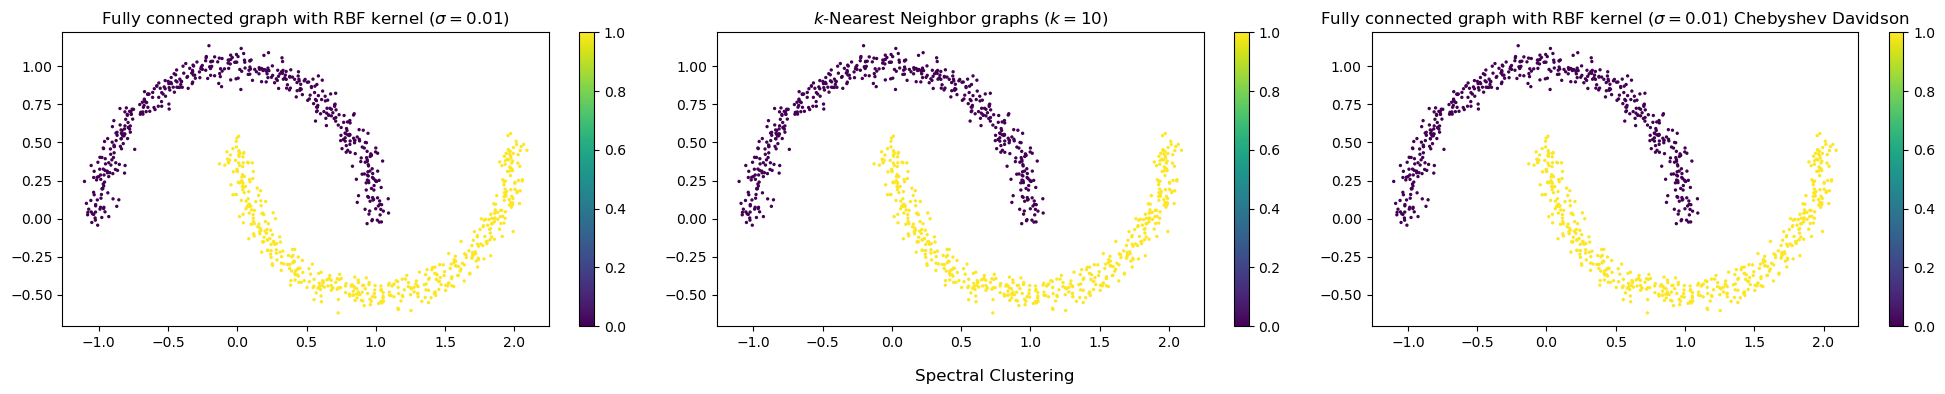

In [31]:
# # Adapted from  https://github.com/zhangyk8/Spectral-Clustering/blob/master/spectral_clustering.py
########################################

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

import chebDev

def writeMatrix(mat, filename):
    with open(filename,'wt') as f:
        for i in range(mat.shape[0]):
            f.write(','.join([str(a) for a in mat[i,:]])+'\n')

    
def checkHermitian(mat, name):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i] and (abs(mat[i,j])>1e-14 and abs(mat[j,i])>1e-14):
                print(name,'not hermitian', i,j, mat[i,j], mat[j,i])
                raise ValueError("Matrix Not Hermitian")

def maskFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i,j]) < 1e-14:
                mat[i,j]=0
    return mat

def makeHermitianIfBelowFloatErr(mat, tol = 1e-14):
    for i in range(mat.shape[0]):
        for j in range(i, mat.shape[1]):
            if mat[i, j] != mat[j, i]:
                if abs(mat[i,j]) < 1e-14 and abs(mat[j,I]) < 1e-14:
                    mat[i,j]=0
                    mat[j,i]=0
                else:
                    print('not hermitian', i,j, mat[i,j], mat[j,i])
                    raise ValueError("Matrix Not Hermitian")
    return mat


def getEig(mat, eig_algo, k=None):
    if eig_algo == 'np_linalg':
        return np.linalg.eig(mat)
    elif eig_algo == 'cheb_dav':
        #mat = makeHermitianIfBelowFloatErr(mat)
        val, vec = chebDev.cheb_dav(mat,k)
        return val, np.asarray(vec)
    else:
        raise Exception ("Invalid Eigen-Algorithm choice. Must be 'np_linalg' or 'cheb_dav'")

# Based on "A Tutorial on Spectral Clustering" written by Ulrike von Luxburg
def Spectral_Clustering(X, K=8, adj=True, metric='euclidean', sim_graph='fully_connect', sigma=1, knn=10, epsi=0.5, normalized=1, eig_algo='np_linalg'):
    '''
    Input: 
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: True;
        metric: string, A parameter passing to "scipy.spatial.distance.pdist()" function for computing the adjacency matrix (deprecated if adj=True). Default: 'euclidean';
        sim_graph: string, Specifying the type of similarity graphs. Choices are ['fully_connect', 'eps_neighbor', 'knn', 'mutual_knn']. Default: 'fully_connect';
        sigma: float, The variance for the Gaussian (aka RBF) kernel (Used when sim_graph='fully_connect'). Default: 1;
        knn: int, The number of neighbors used to construct k-Nearest Neighbor graphs (Used when sim_graph='knn' or 'mutual_knn'). Default: 10;
        epsi: float, A parameter controlling the connections between points (Used when sim_graph='eps_neighbor'). Default: 0.5;
        normalized: int, 1: Random Walk normalized version; 2: Graph cut normalized version; other integer values: Unnormalized version. Default: 1.
    Output:
        sklearn.cluster class, Attributes:
            cluster_centers_ : array, [n_clusters, n_features], Coordinates of cluster centers in K-means;
            labels_ : Labels of each point;
            inertia_ : float, Sum of squared distances of samples to their closest cluster center in K-means;
            n_iter_ : int, Number of iterations run in K-means.
    '''
    # Compute the adjacency matrix
    if not adj:
        Adj_mat = squareform(pdist(X, metric=metric))
    else:
        Adj_mat = X
    # Compute the weighted adjacency matrix based on the type of similarity graphs
    if sim_graph ==  'fully_connect':
        W = np.exp(-Adj_mat/(2*sigma))
    elif sim_graph == 'eps_neighbor':
        W = (Adj_mat <= epsi).astype('float64')
    elif sim_graph == 'knn':
        W = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight (i,j) to 1 when either i or j is within the k-nearest neighbors of each other
        for i in range(Adj_sort.shape[0]):
            W[i,Adj_sort[i,:][:(knn+1)]] = 1
    elif sim_graph == 'mutual_knn':
        W1 = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight W1[i,j] to 0.5 when either i or j is within the k-nearest neighbors of each other (Flag)
        # Set the weight W1[i,j] to 1 when both i and j are within the k-nearest neighbors of each other
        for i in range(Adj_mat.shape[0]):
            for j in Adj_sort[i,:][:(knn+1)]:
                if i == j:
                    W1[i,i] = 1
                elif W1[i,j] == 0 and W1[j,i] == 0:
                    W1[i,j] = 0.5
                else:
                    W1[i,j] = W1[j,i] = 1
        W = np.copy((W1 > 0.5).astype('float64'))
    else:
        raise ValueError("The 'sim_graph' argument should be one of the strings, 'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'!")
        
    # Compute the degree matrix and the unnormalized graph Laplacian
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    checkHermitian(W,'W')
    checkHermitian(D,'D')
    checkHermitian(L,'L')
    # Compute the matrix with the first K eigenvectors as columns based on the normalized type of L
    if normalized == 1:   ## Random Walk normalized version
        # Compute the inverse of the diagonal matrix
        D_inv = np.diag(1/np.diag(D))
        # Compute the eigenpairs of L_{rw}
        mat = np.dot(D_inv, L)
        #checkHermitian(mat,'L_rw')
        #mat = makeHermitianIfBelowFloatErr(mat)
        writeMatrix(W, 'W.mat')
        checkHermitian(mat,'L_rw')

        Lambdas, V = getEig(mat, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
    elif normalized == 2:   ## Graph cut normalized version
        # Compute the square root of the inverse of the diagonal matrix
        D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
        # Compute the eigenpairs of L_{sym}
        Lambdas, V = getEig(np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt), eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        if any(V_K.sum(axis=1) == 0):
            raise ValueError("Can't normalize the matrix with the first K eigenvectors as columns! Perhaps the number of clusters K or the number of neighbors in k-NN is too small.")
        # Normalize the row sums to have norm 1
        V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))
    else:   ## Unnormalized version
        # Compute the eigenpairs of L
        Lambdas, V = getEig(L, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        
    # Conduct K-Means on the matrix with the first K eigenvectors as columns
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)
    return kmeans


def main():
    # Generate a toy dataset...
    moon_data, moon_labels = make_moons(1000, noise=0.05)
    # Compute the adjacency matrix
    Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=0)
    spec_re2 = Spectral_Clustering(Adj_mat, K=2, sim_graph='knn', knn=10, normalized=1)
    spec_re3 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')

    plt.subplot(1, 3, 2)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re2.labels_, s=2)
    plt.colorbar()
    plt.title('$k$-Nearest Neighbor graphs ($k=10$)')

    plt.subplot(1, 3, 3)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re3.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')

    plt.suptitle('Spectral Clustering', y=-0.01)

    # Automatrically adjust padding between subpots 
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()    

In [ ]:

A=np.loadtxt(open("a.mat", "rb"), delimiter=",", skiprows=0)
eigVal_cd, eigVec_cd=chebDev.cheb_dav(A,1000) 
max(eigVal_cd-eigVal_np)


In [15]:
B = np.loadtxt(open('w.mat','rb'), delimiter=',',skiprows=0)
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [16]:
B.shape

(1000, 1000)

In [20]:
for i in range(B.shape[0]):
    for j in range(i, B.shape[1]):
        if B[i, j] != B[j, i]:
            print(i,j, B[i,j], B[j,i])

0 482 1.0 0.0
0 742 1.0 0.0
0 853 1.0 0.0
0 928 1.0 0.0
0 955 1.0 0.0
1 144 1.0 0.0
1 571 0.0 1.0
1 657 1.0 0.0
1 724 1.0 0.0
1 867 1.0 0.0
2 70 1.0 0.0
2 158 1.0 0.0
2 195 1.0 0.0
2 213 1.0 0.0
2 378 0.0 1.0
2 520 1.0 0.0
2 963 1.0 0.0
3 385 0.0 1.0
3 653 0.0 1.0
3 713 0.0 1.0
3 995 0.0 1.0
4 81 0.0 1.0
4 252 0.0 1.0
4 498 0.0 1.0
5 557 0.0 1.0
5 589 1.0 0.0
6 64 0.0 1.0
6 267 0.0 1.0
6 371 0.0 1.0
6 433 0.0 1.0
7 350 1.0 0.0
7 540 1.0 0.0
7 702 0.0 1.0
8 71 0.0 1.0
8 509 1.0 0.0
8 808 1.0 0.0
9 105 1.0 0.0
9 200 1.0 0.0
9 730 1.0 0.0
10 48 0.0 1.0
10 633 1.0 0.0
10 768 1.0 0.0
11 88 1.0 0.0
11 323 1.0 0.0
11 353 1.0 0.0
11 515 1.0 0.0
11 640 1.0 0.0
11 815 1.0 0.0
11 904 1.0 0.0
12 626 0.0 1.0
12 909 1.0 0.0
13 337 1.0 0.0
13 444 1.0 0.0
13 924 1.0 0.0
14 299 1.0 0.0
15 162 0.0 1.0
15 589 0.0 1.0
15 868 0.0 1.0
16 299 1.0 0.0
16 956 1.0 0.0
17 274 0.0 1.0
17 548 0.0 1.0
17 837 1.0 0.0
17 941 1.0 0.0
18 45 1.0 0.0
18 64 1.0 0.0
18 198 1.0 0.0
18 371 1.0 0.0
18 490 0.0 1.0
18 645 1.0 0

In [17]:
np.linalg.eig(B)

EigResult(eigenvalues=array([ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        9.97676987e+00+0.00000000e+00j,  9.89409573e+00+0.00000000e+00j,
        1.01019897e+01+0.00000000e+00j,  1.06573902e+01+0.00000000e+00j,
        1.05842922e+01+0.00000000e+00j,  1.04831364e+01+0.00000000e+00j,
        1.04728281e+01+0.00000000e+00j,  9.86373113e+00+0.00000000e+00j,
        9.58334992e+00+0.00000000e+00j,  9.60754226e+00+0.00000000e+00j,
        1.08209408e+01+0.00000000e+00j,  1.08596478e+01+0.00000000e+00j,
        1.08744480e+01+0.00000000e+00j,  1.09630404e+01+0.00000000e+00j,
        1.03083087e+01+0.00000000e+00j,  1.10000000e+01+0.00000000e+00j,
        1.09980749e+01+0.00000000e+00j,  1.09296618e+01+0.00000000e+00j,
        9.50674950e+00+0.00000000e+00j,  1.09856412e+01+0.00000000e+00j,
        1.09796957e+01+0.00000000e+00j,  1.09032969e+01+0.00000000e+00j,
        1.07356480e+01+0.00000000e+00j,  9.02511661e+00+0.00000000e+00j,
        1.06713467e+01+0.0000